# DATA201 - Project 2

### Ashlee Rosvall
##### ID: 300367094

Please use this page http://apps.ecs.vuw.ac.nz/submit/DATA201 for submission and submit only this single Jupyter notebook with your code added into it at the appropriate places.

The due date is **Friday 7th June, before midnight**.

The dataset for this assignment are files **loan_train.csv** and **loan_test.csv** which are provided with this notebook.

Please choose menu items *Kernel => Restart & Run All* then *File => Save and Checkpoint* in Jupyter before submission.

## Problem Statement

A company deals in all home loans. They have presence across all urban, semi urban and rural areas.
Customers first apply for home loan after that company validates the customer eligibility for loan.

The company wants to automate the loan eligibility process (in real-time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

## Data

| Variable	            | Description                                     |
|-----------------------|-------------------------------------------------|
|``Loan_ID``            |Unique Loan ID                                   |
|``Gender``             |Male / Female                                    |
|``Married``            |Applicant married (Y/N)                          |
|``Dependents``         |Number of dependents                             |
|``Education``          |Applicant Education (Graduate / Under Graduate)  |
|``Self_Employed``      |Self employed (Y/N)                              |
|``ApplicantIncome``    |Applicant income                                 |
|``CoapplicantIncome``  |Coapplicant income                               |
|``LoanAmount``         |Loan amount in thousands                         |
|``Loan_Amount_Term``   |Term of loan in months                           |
|``Credit_History``     |Credit history meets guidelines                  |
|``Property_Area``      |Urban / Semi Urban / Rural                       |
|``Loan_Status``        |Loan approved (Y/N)                              |

Use ``loan_train.csv`` to build a model to predict if a loan application is approved (``Loan_Status`` is the label), and test the model using ``loan_test.csv``. 

## Model Evaluation

Use AUC (area under the receiver operating characteristic curve) as the evaluation metric.

## Guidelines

- This is an End-to-End machine learning project. Please review lecture notes in weeks 6 and 7 carefully before starting the project.
- This is also an *open* project. There is no restriction in using any algorithms or packages, even those which are not discussed in the lectures.
- The followings are expected in this project (**maximum possible points: 15++**):
    + Exploratory analysis and visualisation [**2 points**]
    + Data preparation (outliers and missing values treatment, feature selection, feature engineering, feature scaling, etc. - not all of those steps are required) [**3 points**]
    + Model training (train many quick models, measure and compare their performance, analyze important features and types of errors, ... then short-list the top 3 to 5 most promising models, preferring models that make different types of errors) [**4 points**]
    + Model tuning (fine-tune the hyper-parameters using cross-validation, try ensemble methods, ... then measure the final model's performance on the test set) [**5 points**]
    + Present your solution (present interesting points you noticed along the way (what worked and what did not, your assumptions and your systems limitations), communicate your key findings through beautiful visualizations or easy-to-remember statements, etc.) [**1 point**]
- Bonus points (maximum **2 points**): for those who obtain the highest AUC value on the test set and for those who automate the steps above as much as possible.

In [1]:
import numpy as np
import pandas as pd
import random
import datetime
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

from warnings import filterwarnings
filterwarnings('ignore')


### *Load in the datasets*

In [3]:
train_df = pd.read_csv("loan_train.csv")
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban,Y
1,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban,Y
2,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural,N
3,LP002517,Male,Yes,1,Not Graduate,No,2653,1500.0,113.0,180.0,0.0,Rural,N
4,LP001894,Male,Yes,0,Graduate,No,2620,2223.0,150.0,360.0,1.0,Semiurban,Y


In [4]:
test_df = pd.read_csv("loan_test.csv")

test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001528,Male,No,0,Graduate,No,6277,0.0,118.0,360.0,0.0,Rural,N
1,LP002804,Female,Yes,0,Graduate,No,4180,2306.0,182.0,360.0,1.0,Semiurban,Y
2,LP002945,Male,Yes,0,Graduate,Yes,9963,0.0,180.0,360.0,1.0,Rural,Y
3,LP001784,Male,Yes,1,Graduate,No,5500,1260.0,170.0,360.0,1.0,Rural,Y
4,LP001514,Female,Yes,0,Graduate,No,2330,4486.0,100.0,360.0,1.0,Semiurban,Y


In [5]:
#Remove any personal potential identifiers from the dataset
train_df.drop(["Loan_ID"], axis=1, inplace=True)
test_df.drop(["Loan_ID"], axis=1, inplace=True)

## Data Exploration and Analysis

Check for any missing values

In [6]:
train_df.isnull().values.any()

True

List the numerical and categorical attributes of the dataset

In [7]:
numerical_attributes = list(train_df.select_dtypes(include=[np.number]))
numerical_attributes

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [8]:
categorical_attributes = list(train_df.select_dtypes(include=['object']))
#Drop the class label for analysis purposes
categorical_attributes = categorical_attributes[:-1]
categorical_attributes

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

Check the distribution of the two classes

Text(0,0.5,'Frequency')

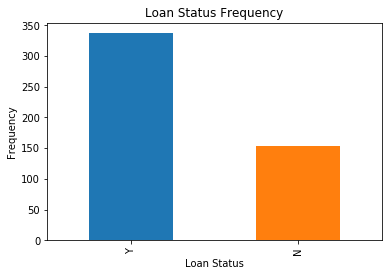

In [9]:
train_df.Loan_Status.value_counts().plot(kind='bar')
plt.title('Loan Status Frequency')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')

##### Analyse the unique values of each feature

In [10]:
for column in train_df.columns:
    print(column, ":", train_df[column].unique(), "\n")

Gender : ['Male' 'Female' nan] 

Married : ['No' 'Yes' nan] 

Dependents : ['0' '1' '2' nan '3+'] 

Education : ['Graduate' 'Not Graduate'] 

Self_Employed : ['No' 'Yes' nan] 

ApplicantIncome : [ 3254  3315  3340  2653  2620  1875  3000  2383  7441  4583 37719 13650
  2876  3750  2583  6000  4166  7333  4333  4288  4000  4695  2045 10000
  3500  5568  6083  5746  3593  3167  2500  2995  3846  3583  5333  5935
  4400  1916  1000  4167  4133  2014  3189  3095  5000  3463  5726  8333
  3547 14583  5417  4860  5285 14999  5818  6700  3775  2917  2400  3727
  5821  3717  4547  3541  6783  2600  2132  1809  2750  3716  5649  1378
  7740  2213  5800 17500  2378  5391  3497  2275  2609  3667  4755  1820
  7142  6080  3159  4735  9703  5829  6875 20233  3833  3276  3600 16692
  3083  6540  1977  8072  4300  1668  6065  1800 10416  5250  5923  7200
  4554 81000  4350  3237  3466  3902  2787  6383  3166  6050  7250  4095
 63337  2083  5316  2395  3675 13262  2667  2929  1025  2366 39999  2894
  

###### Describe the numerical data features

In [11]:
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,491.000000,491.000000,471.000000,479.000000,448.000000
mean,5529.997963,1569.537271,147.309979,341.286013,0.850446
std,6457.784318,2789.523475,87.096507,65.855043,0.357032
min,210.000000,0.000000,9.000000,12.000000,0.000000
25%,2906.000000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1032.000000,128.000000,360.000000,1.000000
75%,5825.000000,2241.000000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


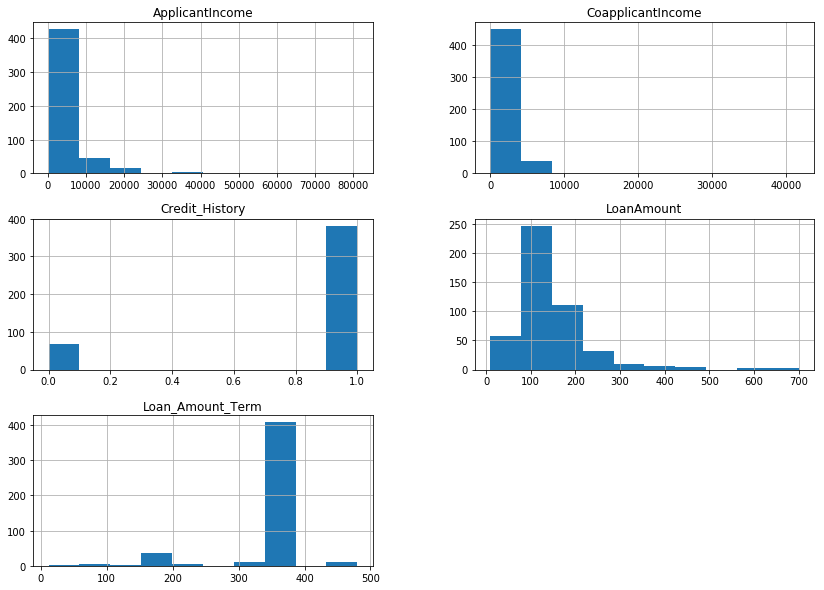

In [12]:
train_df.hist(bins = 10, figsize = (14, 10))
plt.show()

Outliers found in unique values backed up. No normal distributions to the data, uneven split in credit_history and all features are skewed left

For each numerical value
Get the other numerical values grouped by the mean to see if this value explains variance. If there is a wide range between the other variables based on this feature and it's values then it may be highly useful for the predictor

In [13]:
train_df.groupby("Loan_Status").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,
N,5680.545455,1764.103896,148.165517,338.756757,0.567376
Y,5461.201780,1480.625519,146.929448,342.416918,0.980456


Wide range of credit history suggests that is useful in predicting the class label, as does the applicant income. the loan amount appears to be all but useless having near identical values on average for both class labels

In [14]:
train_df.groupby("Credit_History").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
Credit_History,,,,
0.0,6306.820896,1501.119403,145.062500,332.459016
1.0,5467.813648,1465.784252,145.147945,342.880000


credit history of 1 has higher applicant income, lower coapplicant income, similar loan amounts between the two feature values

Text(0,0.5,'Loan Status Frequency')

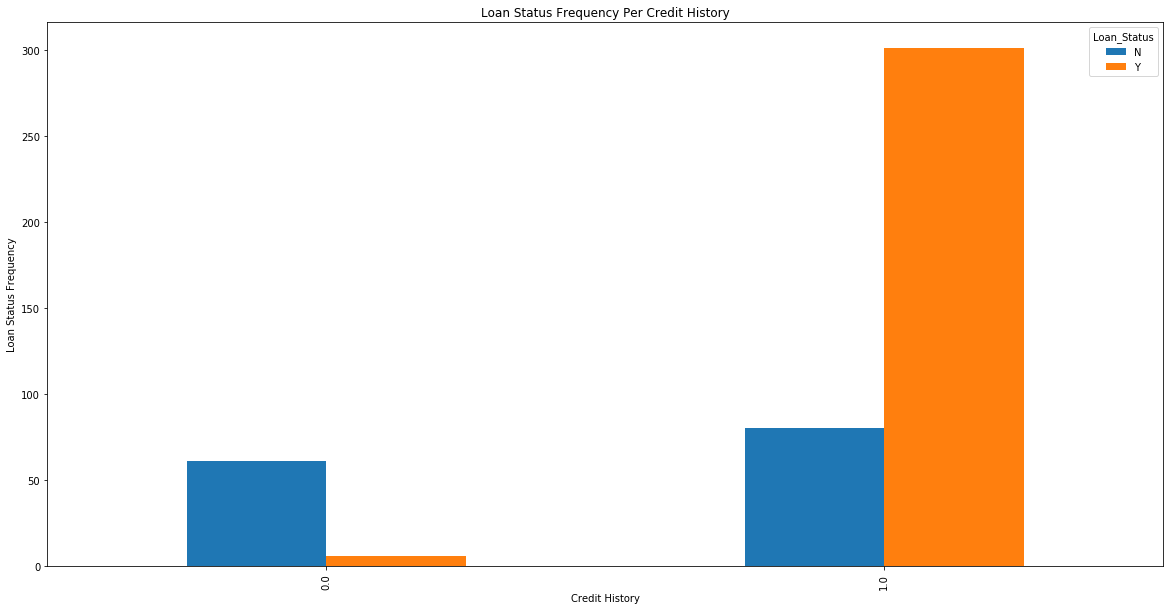

In [15]:
pd.crosstab(train_df.Credit_History, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10))
plt.title('Loan Status Frequency Per Credit History')
plt.xlabel('Credit History')
plt.ylabel('Loan Status Frequency')

In [16]:
train_df.groupby("Married").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Married,,,,,
No,5104.893491,1219.840237,131.539877,351.658537,0.872611
Yes,5748.843260,1767.196865,155.633987,335.653846,0.836806


Large difference with most other features, useful to the predictors. Married people have higher applicant income and coapplicant income, other features relatively balanced

In [17]:
train_df.groupby("Gender").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Gender,,,,,
Female,4725.287356,1159.839080,124.035294,351.428571,0.871795
Male,5529.109415,1673.846819,150.549333,339.156250,0.850000


wide difference between genders and the applicant income/coapplicant income, both lower for female gender, other features relatively balanced

In [18]:
train_df.groupby("Property_Area").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Property_Area,,,,,
Rural,5690.324138,1622.096552,152.474820,343.014085,0.810606
Semiurban,5369.967391,1492.168478,148.000000,345.692308,0.888889
Urban,5568.259259,1610.369136,141.810458,334.529032,0.841379


Rural buyers have generally less applicant income, higher coapplicant income, higher loan amount 

Text(0,0.5,'Loan Status')

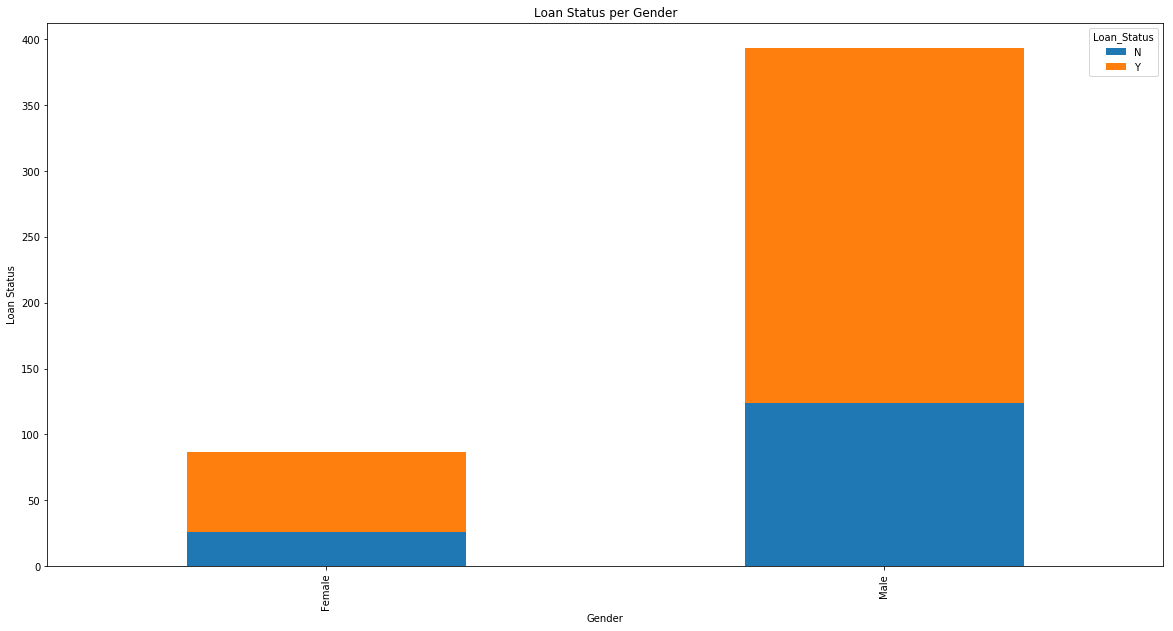

In [19]:
pd.crosstab(train_df.Gender, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10), stacked = True)
plt.title('Loan Status per Gender')
plt.xlabel('Gender')
plt.ylabel('Loan Status')
#shows useless 

Both genders have a relatively balanced division between the two class labels despite higher occurence of male gender in dataset

Text(0,0.5,'Loan Status')

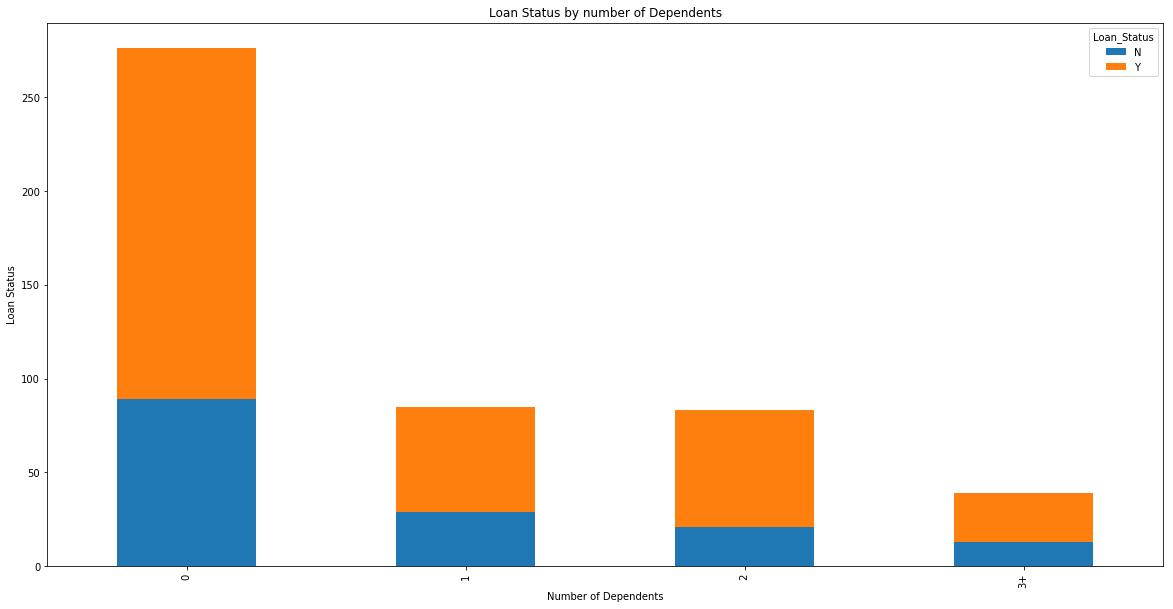

In [20]:
pd.crosstab(train_df.Dependents, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10), stacked = True)
plt.title('Loan Status by number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Loan Status')

Roughly balanced division of class labels despite much higher occurence of 0 dependents within the dataset, might not be a useful predictor

Text(0,0.5,'Loan Status')

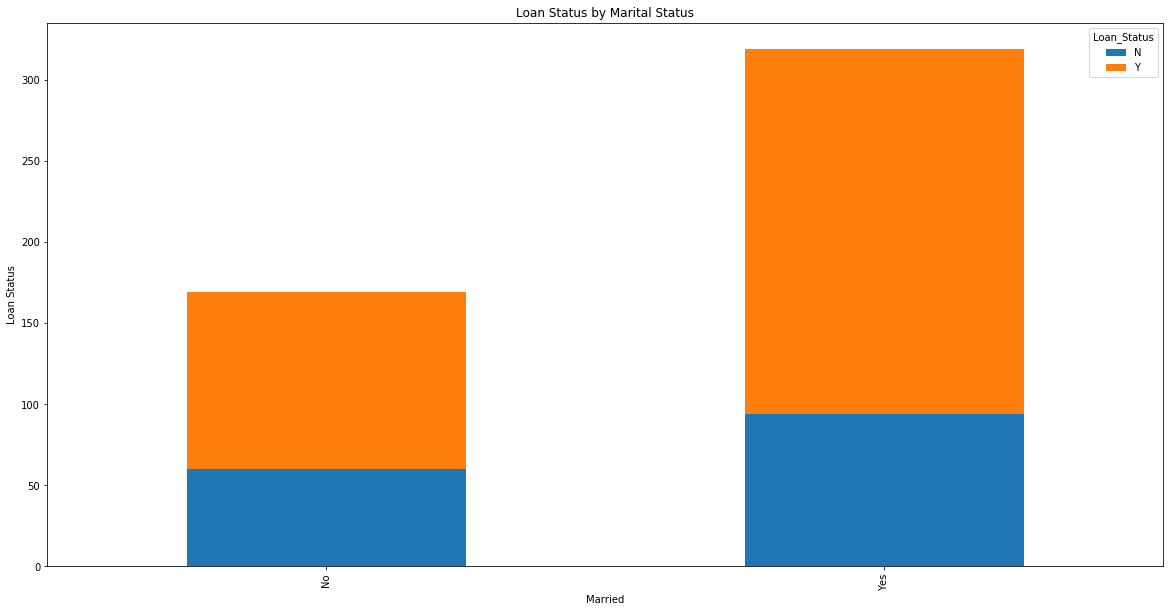

In [21]:
pd.crosstab(train_df.Married, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10), stacked = True)
plt.title('Loan Status by Marital Status')
plt.xlabel('Married')
plt.ylabel('Loan Status')

Married applicants have a higher percentage of Y class labels than single applicants. Could be useful as a predictor

Text(0,0.5,'Loan Status')

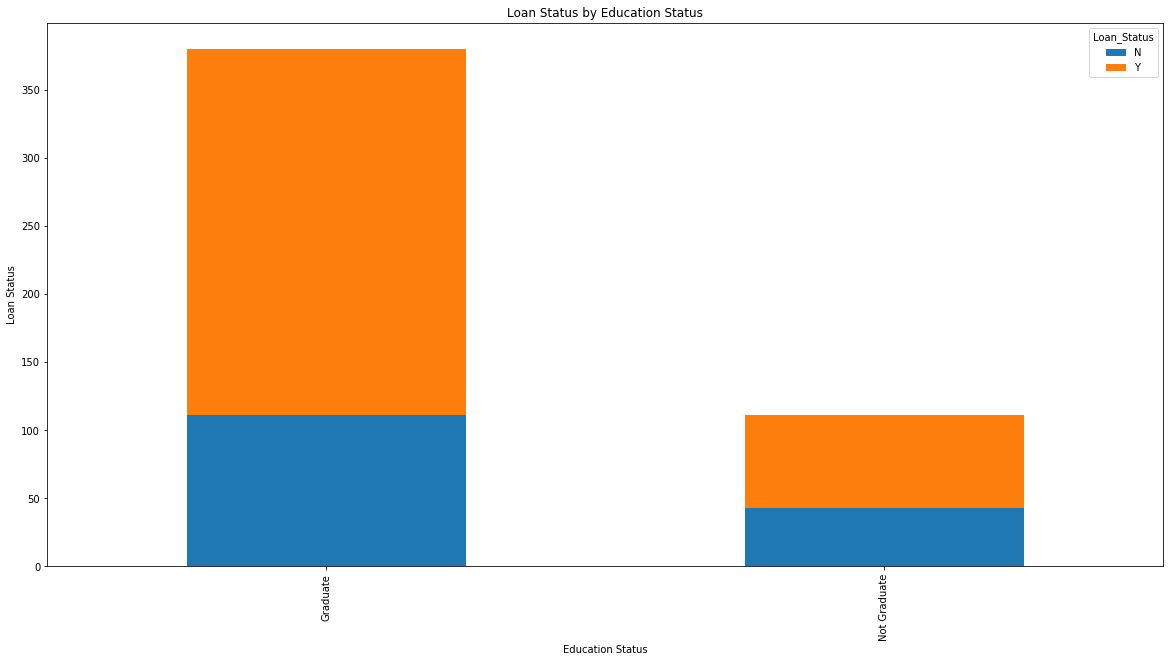

In [22]:
pd.crosstab(train_df.Education, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10), stacked = True)
plt.title('Loan Status by Education Status')
plt.xlabel('Education Status')
plt.ylabel('Loan Status')

Education status appears to be evenly divided between the two class labels, suggests not a good predictor

Text(0,0.5,'Loan Status')

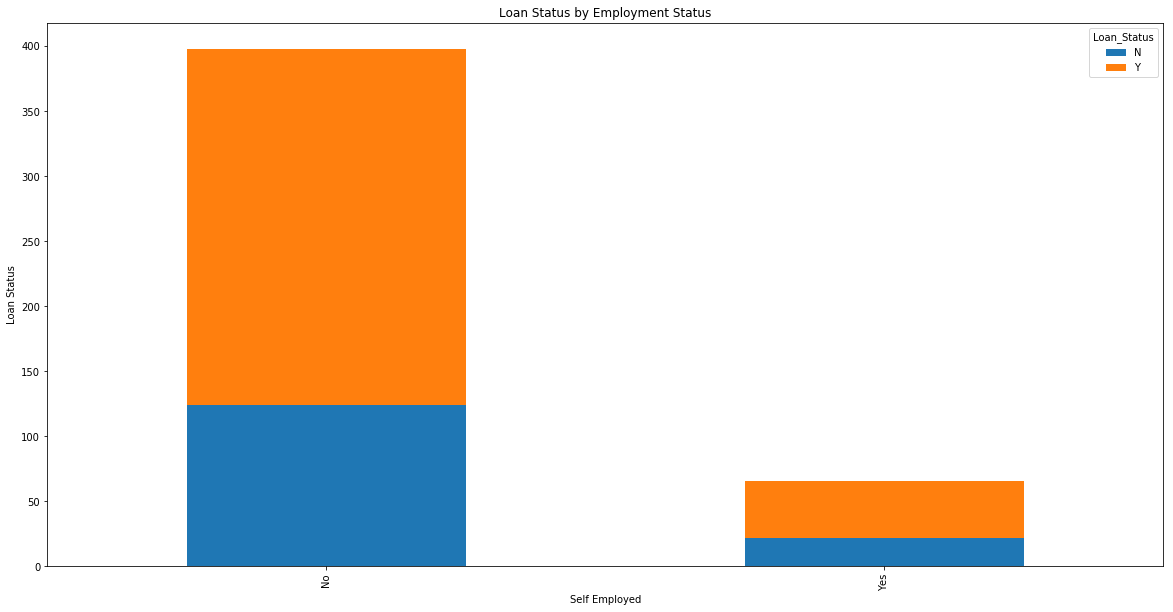

In [23]:
pd.crosstab(train_df.Self_Employed, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10), stacked = True)
plt.title('Loan Status by Employment Status')
plt.xlabel('Self Employed')
plt.ylabel('Loan Status')

Despite the difference in number of each value in the feature, the division of class labels appears to be relatively even. Does not appear to be a predictor

Text(0,0.5,'Loan Status')

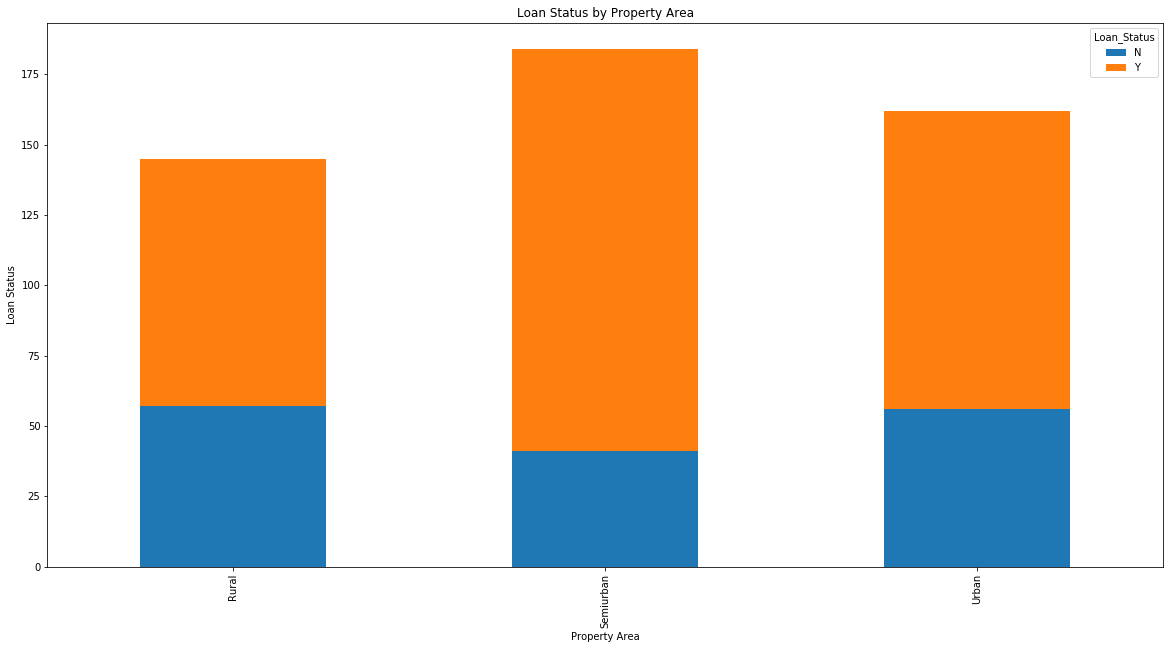

In [24]:
pd.crosstab(train_df.Property_Area, train_df.Loan_Status).plot(kind = 'bar', figsize = (20,10), stacked = True)
plt.title('Loan Status by Property Area')
plt.xlabel('Property Area')
plt.ylabel('Loan Status')

Semi-urban appears to be a better predictor of class label than the other two feature values

#### Exploration of null values

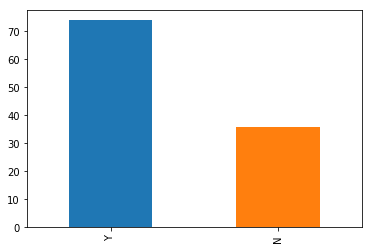

In [25]:
#Extract all instances with null/missing values, group by them then plot to get a division of class
null_data = train_df[train_df.isnull().any(axis=1)]
null_data.groupby(null_data.Loan_Status)
null_data.Loan_Status.value_counts().plot(kind='bar')

More Y instances have missing data than N,follows the expectation as the dataset is split to more Y instances than N

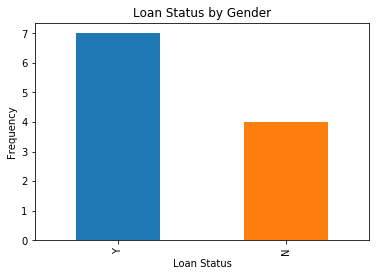

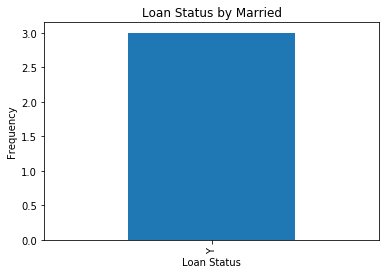

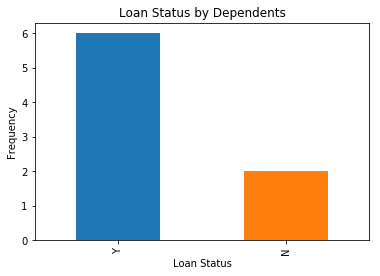

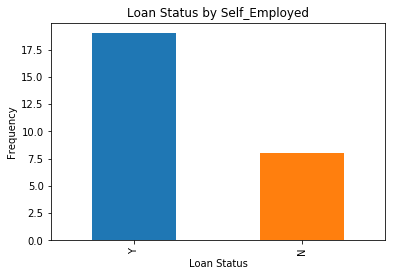

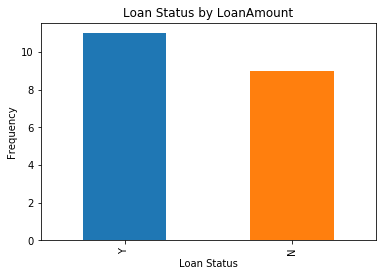

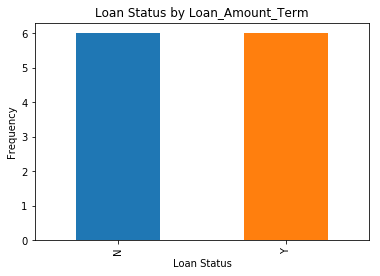

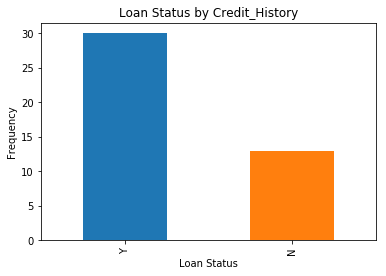

In [26]:
#Plot the number of missing values per column by the class label
for c in train_df.columns:
    if train_df[c].isnull().sum() > 0:
        data = train_df[pd.isnull(train_df[c])]
        data.Loan_Status.value_counts().plot(kind='bar')
        plt.title('Loan Status by ' + str(c))
        plt.xlabel('Loan Status')
        plt.ylabel('Frequency')
        plt.show()


Interesting notes:
- Married only has missing data for the Y class
- Loan Status has more missing Y data than N, roughly on par with division of labels in dataset
- even split between Loan_Amount and Loan Amount_Term for the classes
- Self employed and dependents appear to have the same distribution of class label for missing data


## Data cleansing and preparation

First remove outliers

In [27]:
#remove the outliers
train_df.drop(train_df[train_df['ApplicantIncome'] == 81000].index, inplace = True)
train_df.drop(train_df[train_df['CoapplicantIncome'] == 41667].index, inplace = True)

#train_df.drop(train_df[train_df['ApplicantIncome'] == 63337].index, inplace = True)

train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,489.000000,489.000000,469.000000,477.000000,447.000000
mean,5386.120654,1490.748057,146.424307,341.584906,0.852349
std,5488.897616,2123.058730,86.214781,65.571595,0.355151
min,210.000000,0.000000,9.000000,12.000000,0.000000
25%,2917.000000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1032.000000,128.000000,360.000000,1.000000
75%,5821.000000,2232.000000,167.000000,360.000000,1.000000
max,63337.000000,20000.000000,700.000000,480.000000,1.000000


Now process the data to remove the missing values. Due to the high number of missing values across the dataset (approx 20-25%) of the training data, we cannot simply drop the data. The approach taken in this project is to:

a) should the number of missing values of a feature be less than 0.025% of the dataset (approx 12 per feature type), drop the missing values of the dataset. Should every feature have this number of missing values at most we would be dropping at most 11 * 0.025 = 0.275 = 2.75% of the dataset. this would still provide plenty of information while removing the missing values

b) should the number of missing values of a feature be greater than 0.025% of the dataset, then use the pandas interpolation function in order to find the nearest neighbour to the instance with missing values and interpolate the missing values based on this. While this does bring in a problem of oversaturating the dataset with similar values, this avoids the flat rule of just replacing every feature with the most common value, ensuring there is some variance in the final dataset, and ensuring that there is enough information left in the dataset to make models useful, which would not be the case from simply dropping these instances

This behaviour is repeated for the test set, though the threshold for dropping values is much lower due to the smaller test size, sitting at approximately 3 instances of missing data per features rather than twelve.

In [28]:
l = train_df.isna().sum()
subset =[]
x = 0
col_drop_threshold = np.round(len(train_df)*0.025)

for c in train_df.columns:
    if l[c] < col_drop_threshold:
        subset.append(c)
        x = x+l[c]

print("Total number of rows dropped from training data is: " + str(x))
train_df = train_df.dropna(axis=0, subset=subset)

l = test_df.isna().sum()
subset =[]
x = 0
col_drop_threshold = np.round(len(test_df)*0.025)

for c in train_df.columns:
    if l[c] < col_drop_threshold:
        subset.append(c)
        x = x+l[c]

test_df = test_df.dropna(axis=0, subset=subset)
print("Total number of rows dropped from test data is: " + str(x))

Total number of rows dropped from training data is: 22
Total number of rows dropped from test data is: 6


In [29]:
train_df = train_df.interpolate()
test_df = test_df.interpolate()

train_df= train_df.fillna(method="ffill")
test_df = test_df.fillna(method="ffill")

In [30]:
for c in numerical_attributes:
    train_df[c] = np.round(train_df[c])
    test_df[c] = np.round(test_df[c])
for column in train_df.columns:
    print(column, ":", train_df[column].unique(), "\n")

Gender : ['Male' 'Female'] 

Married : ['No' 'Yes'] 

Dependents : ['0' '1' '2' '3+'] 

Education : ['Graduate' 'Not Graduate'] 

Self_Employed : ['No' 'Yes'] 

ApplicantIncome : [ 3254  3315  3340  2653  2620  1875  3000  2383  7441  4583 37719  2876
  3750  2583  6000  4166  7333  4333  4288  4000  4695  2045 10000  3500
  5568  6083  5746  3593  3167  2500  2995  3846  5333  5935  4400  1916
  1000  4167  4133  2014  3189  3095  5000  3463  5726  8333  3547 14583
  5417  4860  5285 14999  5818  6700  3775  2917  2400  3727  5821  3717
  4547  3541  6783  2600  2132  1809  2750  3716  5649  1378  7740  2213
  5800 17500  2378  5391  3497  2275  2609  3667  4755  1820  7142  6080
  3159  9703  5829  6875 20233  3833  3276  3600  3083  6540  1977  8072
  4300  1668  6065  1800 10416  5250  5923  7200  4554  4350  3237  3466
  3902  2787  6383  3166  6050  7250  4095 63337  2083  5316  2395  3675
 13262  2667  2929  1025  2366 39999  2894  3232  6822  4354  3867  9083
  2965  2708  7451

Next, we use the categorical and numerical columns discovered above to efficiently one hot encode the categorical columns and to standardise the numerical ones. The decision was made not to use a pipeline due to the difficulty of understanding the model which was built as the pipeline destroyed the integrity of the columns and ease of understanding of the dataset. Instead the numerical values were standardised and the categoricals had dummies created to keep the integrity of the dataset and ease of understanding in subsequent models which were built


In [31]:
y_train = train_df['Loan_Status'].copy()
y_test = test_df['Loan_Status'].copy()

y_train.replace('Y', 1, inplace=True)
y_train.replace('N', 0, inplace=True)

y_test.replace('Y', 1, inplace=True)
y_test.replace('N', 0, inplace=True)


In [32]:
train_features = train_df.drop(['Loan_Status'], axis=1)
test_features = test_df.drop(['Loan_Status'], axis=1)

scaler = StandardScaler()
train_features[numerical_attributes] = scaler.fit_transform(train_features[numerical_attributes])
test_features[numerical_attributes] = scaler.transform(test_features[numerical_attributes])

X_train = pd.get_dummies(train_features)
X_test = pd.get_dummies(test_features)

X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,-0.391301,-0.706680,-1.154794,0.283490,0.418330,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,-0.379178,-0.706680,-0.589631,0.283490,0.418330,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0
2,-0.374210,0.089778,0.073821,0.283490,-2.390457,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0
3,-0.510740,-0.008033,-0.380766,-2.467514,-2.390457,0,1,0,1,0,1,0,0,0,1,1,0,1,0,0
4,-0.517299,0.328715,0.073821,0.283490,0.418330,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0


Now transform the data into pca components using the training data, aiming for ~95% variance explained. In this dataset, 96% was achieved with 12 components

In [33]:
pca = PCA(n_components = 12)
pca.fit(X_train)  
print(pca.explained_variance_ratio_) 
print(np.sum(pca.explained_variance_ratio_))

[0.21650477 0.14948457 0.1442466  0.12450113 0.07308957 0.04754592
 0.04553211 0.03982222 0.03709897 0.03569441 0.02822182 0.02508853]
0.9668306254531089


In [34]:
x_pca_train = pca.transform(X_train)
x_pca_test = pca.transform(X_test)

In [35]:
#Method to easily evalute the methods based on the predicted values and whether or not this is test data

def evaluate(predicted_values, test):
    if(test== False):
        train_auc = roc_auc_score(predicted_values, y_train)
        train_acc = accuracy_score(predicted_values, y_train)
        print("Training auc = " + str(train_auc))
        print("Training accuracy = " + str(train_acc))
    else:
        test_auc = roc_auc_score(predicted_values, y_test)
        test_acc = accuracy_score(predicted_values, y_test)
        print("Test auc = " + str(test_auc))
        print("Test accuracy = " + str(test_acc))


## Train the models
#### Start by training ten common models to see their performance to narrow down later

#### KNN

In [36]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)
tra_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.7788273204018449
Training accuracy = 0.8106382978723404
Test auc = 0.7981601731601733
Test accuracy = 0.8290598290598291


#### SVM

In [37]:
svm = SVC()
svm.fit(X_train, y_train)
tra_preds = svm.predict(X_train)
test_preds = svm.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.8190574288915392
Training accuracy = 0.7936170212765957
Test auc = 0.8279370952821461
Test accuracy = 0.8290598290598291


#### Logistic Regression

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
tra_preds = logreg.predict(X_train)
test_preds = logreg.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.8126785714285714
Training accuracy = 0.7914893617021277
Test auc = 0.8439130434782608
Test accuracy = 0.8461538461538461


#### Decision Tree

In [39]:
dt = DecisionTreeClassifier(max_depth = 10)
dt.fit(X_train, y_train)
tra_preds = dt.predict(X_train)
test_preds = dt.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.9387675420004016
Training accuracy = 0.9382978723404255
Test auc = 0.7015404364569962
Test accuracy = 0.7435897435897436


#### Naive Bayes

In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)
tra_preds = nb.predict(X_train)
test_preds = nb.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.7760695187165775
Training accuracy = 0.7914893617021277
Test auc = 0.7887867647058824
Test accuracy = 0.8205128205128205


#### Multi Layer Perceptron

In [41]:
mlp = MLPClassifier(max_iter = 2000)
mlp.fit(X_train, y_train)
tra_preds = mlp.predict(X_train)
test_preds = mlp.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.9643360338147235
Training accuracy = 0.9617021276595744
Test auc = 0.7027573529411765
Test accuracy = 0.7521367521367521


#### Ridge Classification

In [42]:
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
tra_preds = ridge.predict(X_train)
test_preds = ridge.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.8126785714285714
Training accuracy = 0.7914893617021277
Test auc = 0.8439130434782608
Test accuracy = 0.8461538461538461


#### Linear SVM

In [43]:
linearsvm = LinearSVC(max_iter = 10000)
linearsvm.fit(X_train, y_train)
tra_preds = linearsvm.predict(X_train)
test_preds = linearsvm.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.8126785714285714
Training accuracy = 0.7914893617021277
Test auc = 0.8439130434782608
Test accuracy = 0.8461538461538461


#### Ada Boost Classifier

In [44]:
ada = AdaBoostClassifier(n_estimators = 50)
ada.fit(X_train, y_train)
tra_preds = ada.predict(X_train)
test_preds = ada.predict(X_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.8419486256977329
Training accuracy = 0.8404255319148937
Test auc = 0.7728731942215089
Test accuracy = 0.8034188034188035


From the above we can see that the best performing algorithms based on the auc are the linearsvm, logistic regression, svm, knn and the naive bayes. The decision tree, despite inbuilt feature selection, did not perform as well on the untransformed data. However due to this selection the adaboost classifier is going to be taken through to add variety in the ensemble models built after this point.

The Linear svm, Logistic Regression and Ridge regression all performed the same with their default values on the dataset. Due to the nature of the logistic regression being able to specify penalty which is useful for an unbalanced dataset, it will be taken through to the ensemble model

Both the knn and naive bayes, as simple yet efficient models will also be taken through to the next ensemble model. There are no penalty terms to be taken into consideration with these models due to how they are built, but there is the variation of number of neighbours that can be tuned for the knn model to find the best fit.

The linearsvm and svc also performed well. However due to the similarities between the linear svm results and the logistic regression the svc will be used in ensemble models to improve performance and add more variance to the model.

These models will be run with the pca components on the base settings to see which of the transformed features and the naive will be more useful to the models. A normalisation will also be run on the models.

#### Testing the PCA component performance against pure dataset

In [45]:
#PCA component transforms 
print("knn")
knn.fit(x_pca_train, y_train)
tra_preds = knn.predict(x_pca_train)
test_preds = knn.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

print("Logistic Regression")
lr = LogisticRegression()
lr.fit(x_pca_train, y_train)
tra_preds = lr.predict(x_pca_train)
test_preds = lr.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

print(" ada boost")
ada.fit(x_pca_train, y_train)
tra_preds = ada.predict(x_pca_train)
test_preds = ada.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)


knn
Training auc = 0.7834187963212854
Training accuracy = 0.8148936170212766
Test auc = 0.7757839721254355
Test accuracy = 0.811965811965812
Logistic Regression
Training auc = 0.8126785714285714
Training accuracy = 0.7914893617021277
Test auc = 0.8439130434782608
Test accuracy = 0.8461538461538461
 ada boost
Training auc = 0.8728535353535354
Training accuracy = 0.8680851063829788
Test auc = 0.7527472527472527
Test accuracy = 0.7863247863247863


Due to an increase in both accuracy and auc the PCA components have been chosen to run the dataset 

### Model Tuning and Ensembling

#### KNN Tuning

In [46]:
knn_params = {'knn__n_neighbors' : np.arange(2,11), 'knn__weights':('uniform', 'distance')}
knn_pipeline = Pipeline(steps = [('knn', KNeighborsClassifier())])
knn_GSCV = GridSearchCV(knn_pipeline, param_grid = knn_params, cv=5, scoring='roc_auc')
knn_GSCV.fit(x_pca_train, y_train)

tra_preds = knn_GSCV.predict(x_pca_train)
test_preds = knn_GSCV.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 1.0
Training accuracy = 1.0
Test auc = 0.8098118279569892
Test accuracy = 0.8205128205128205


#### Logistic Regression Tuning

In [47]:
lr_params = {'lr__penalty' : ('l1', 'l2'), 'lr__C' : np.arange(0.1, 5, 0.1) }

lr_pipeline = Pipeline(steps= [('lr', LogisticRegression(class_weight='balanced'))])

lr_GSCV = GridSearchCV(lr_pipeline, param_grid = lr_params, cv=5, scoring='roc_auc')
lr_GSCV.fit(x_pca_train, y_train)

tra_preds = lr_GSCV.predict(x_pca_train)
test_preds = lr_GSCV.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.7727299536996078
Training accuracy = 0.7851063829787234
Test auc = 0.7887867647058824
Test accuracy = 0.8205128205128205


#### Ada boost tuning

In [48]:
ada_params = {'ada__learning_rate' : np.arange(0.1, 3, 0.1), 'ada__n_estimators' : np.arange(80,120, 10) }
ada_pipeline = Pipeline(steps = [('ada', AdaBoostClassifier())])
ada_GSCV = GridSearchCV(ada_pipeline, param_grid = ada_params, cv=5, scoring='roc_auc')
ada_GSCV.fit(x_pca_train, y_train)

tra_preds = ada_GSCV.predict(x_pca_train)
test_preds = ada_GSCV.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.8562316323804435
Training accuracy = 0.8212765957446808
Test auc = 0.8111111111111111
Test accuracy = 0.8290598290598291


#### SVM Tuning

In [49]:
svc_params = {'svc__C' : np.arange(0.25, 10, 0.25), 'svc__max_iter': np.arange(-1, 100, 25), 'svc__gamma': ('auto', 'scale')}
svc_pipeline = Pipeline(steps = [('svc', SVC(probability=True, class_weight='balanced'))])
svc_GSCV = GridSearchCV(svc_pipeline, param_grid = svc_params, cv=5, scoring='roc_auc')
svc_GSCV.fit(x_pca_train, y_train)

tra_preds = svc_GSCV.predict(x_pca_train)
test_preds = svc_GSCV.predict(x_pca_test)

evaluate(tra_preds, False)
evaluate(test_preds, True)

Training auc = 0.7711796675191815
Training accuracy = 0.7914893617021277
Test auc = 0.8102941176470588
Test accuracy = 0.8376068376068376


### Final Ensemble Model
#### Voting classifier built from the previous four trained models 

In [50]:
vc = VotingClassifier(estimators=[('lr', lr_GSCV), ('knn', knn_GSCV), ('svc',svc_GSCV), ('ada', ada_GSCV)], voting='soft')
vc.fit(x_pca_train, y_train)

train_preds = vc.predict(x_pca_train)
test_preds = vc.predict(x_pca_test)

evaluate(train_preds, False)
print("")
evaluate(test_preds, True)

print("")
print(classification_report(train_preds, y_train))
print(classification_report(test_preds, y_test))

Training auc = 0.9670833333333333
Training accuracy = 0.9744680851063829

Test auc = 0.8360215053763442
Test accuracy = 0.8376068376068376

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       150
           1       0.98      0.99      0.98       320

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

              precision    recall  f1-score   support

           0       0.57      0.83      0.68        24
           1       0.95      0.84      0.89        93

    accuracy                           0.84       117
   macro avg       0.76      0.84      0.78       117
weighted avg       0.87      0.84      0.85       117



## Solution and Findings

The solution that I chose for the classification of this dataset was to use an ensemble model which trained from a logistic regression model, an ada boost model, a support vector classifier and a k-nearest neighbour model. 

After initial data visualisation and expoloration i discovered that this dataset contained null values and had an imbalance between the two classes. The missing/null data I explored further, seeing that there was a mostly balanced split between the classes for each feature's missing data, and that the overall missing data was not a large amount but it was above the 5% drop rate. Because of this, I chose to drop some data if it was below a small percentage and to interpolate the rest. Merely interpolating the data led to a decreased performance on the final models, informing the decision to drop the smaller percentages of missing data. 

An assumption about the dataset was that the interpolating would add more information than dropping the instances would remove. The catch to this was that there could be an added bias to the data due to interpolating the nearest values to the instance in the set e.g. all of the loanamounts interpolated could be wildly inaccurate to the ground truth of the instance

The models trained on both the standardised data from the training set and the components achieved through pca. After analysing the outputs of the two options I decided to use the pca components, which explained 96.7% of the variance in the dataset, in further analysis.

Each of the chosen four models was then used with a grid search cross validation. This trained the models to have parameters that would perform well on the classification metrics, which would boost the final score. Once I had these well trained models I used a voting classifier to achieve the final scores on the performance metrics

The most difficult score to optimise in the metrics was the precision, which is a key component of the roc auc measure. This was noted as being caused by the class imbalance. In order to work around this, and train a well performing model, a setting in each the Logistic Regression and SVM models was changed to take this imbalance into consideration. The overall models performed much better when the class weights were set to balanced

##### Key observations:
- There was an imbalance between the classes which needed to be taken into account
- The missing data needed to be handled in a way which both dropped some smaller number of instances and interpolated the others. This could impact on accuracy
- The most difficult part of the metrics to balance was the precision, which needed the l1 solver and imbalance to be taken into account
- There were outliers in the applicant income column which needed to be handled in order to increase the overall roc score
- No normal distribution within the features
- Credit History was a very useful features with clear difference in how the class labels were predicted
- Self employed feature had the most missing data values


#### Final accuracies of the model and discussion
The final auc scores of the models for test and training are:

Training: 0.96

Test: 0.84

The scores were lowered by the lower precision of the two models, which is caused by the imbalance in the dataset and has been taken into account as much as possible. Running the soft voting system also improves the precision score and lowers the impact of the imbalanced data, leading to a higher auc score

The confusion matrix of the final model is:

confusion_Matrix | 0 | 1
--- | --- | ---
0 | 22 | 5
1 | 13 | 77 

which shows that the auc, precision, f1 score and recall are highly relevant measures and also show the good fit of the model to the data. The metrics of classification performance show that there is not a naive assumption that the model is only predicting the larger class, which is backed up by the confusion matrix.

The model built in this project is well trained, created from an ensemble and adept at predicting the values from the dataset. More data and more balanced data would improve the auc score, but from the given test and training datasets the performance metrics show the ensemble model fits the data well and performs better than any individual model created.